In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, when, lag, avg, sum as _sum
from pyspark.sql.window import Window
import json
from shapely.geometry import shape, Point

# Initialize Spark session
spark = SparkSession.builder \
    .appName("NYC Taxi Data Analysis") \
    .getOrCreate()

# Load CSV data into Spark DataFrame
taxi_data_path = "sample.csv"
taxi_df = spark.read.csv(taxi_data_path, header=True, inferSchema=True)

# Load GeoJSON data
with open('nyc-boroughs.geojson') as f:
    geojson_data = json.load(f)


In [16]:
# Define a function to map coordinates to boroughs using GeoJSON data
def get_borough(longitude, latitude):
    point = Point(longitude, latitude)
    for feature in geojson_data['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['borough']
    return None

# Register UDF in Spark
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

get_borough_udf = udf(get_borough, StringType())

# Add borough columns to the DataFrame
taxi_df = taxi_df.withColumn('pickup_borough', get_borough_udf(col('pickup_longitude'), col('pickup_latitude')))
taxi_df = taxi_df.withColumn('dropoff_borough', get_borough_udf(col('dropoff_longitude'), col('dropoff_latitude')))


In [20]:
# Convert timestamps to Unix time for duration calculation
taxi_df = taxi_df.withColumn('pickup_time', unix_timestamp('pickup_datetime', 'yyyy-MM-dd HH:mm:ss'))
taxi_df = taxi_df.withColumn('dropoff_time', unix_timestamp('dropoff_datetime', 'yyyy-MM-dd HH:mm:ss'))

# Calculate trip duration
taxi_df = taxi_df.withColumn('duration', col('dropoff_time') - col('pickup_time'))

# Filter out invalid data
taxi_df = taxi_df.filter((col('duration') > 0) & (col('duration') <= 4 * 3600))


In [21]:
# Define window partitioned by taxi and ordered by pickup time
window_spec = Window.partitionBy('medallion').orderBy('pickup_time')

# Calculate idle time
taxi_df = taxi_df.withColumn('prev_dropoff_time', lag('dropoff_time').over(window_spec))
taxi_df = taxi_df.withColumn('idle_time', col('pickup_time') - col('prev_dropoff_time'))

# Filter out idle times over 4 hours
taxi_df = taxi_df.withColumn('idle_time', when(col('idle_time') <= 4 * 3600, col('idle_time')).otherwise(0))

# Calculate total idle time and total active time per taxi
utilization_df = taxi_df.groupBy('medallion').agg(
    (_sum(col('duration')) / (_sum(col('duration')) + _sum(col('idle_time')))).alias('utilization')
)

utilization_df.show()


+--------------------+-------------------+
|           medallion|        utilization|
+--------------------+-------------------+
|000318C2E3E638158...| 0.4444444444444444|
|002E3B405B6ABEA23...| 0.3886363636363636|
|0030AD2648D81EE87...| 0.7333333333333333|
|0036961468659D0BF...|0.37213740458015265|
|0038EF45118925A51...|0.41935483870967744|
|0053334C798EC6C8E...| 0.2608695652173913|
|005DED7D6E6C45441...| 0.4935400516795866|
|005F00B38F46E2100...| 0.3060217176702863|
|00790C7BAD30B7A9E...|0.32802547770700635|
|0094A03FFE6BAFBE0...|  0.664179104477612|
|009D3CCA83486B03F...| 0.3240832507433102|
|009E68CADCB1BCF73...|                1.0|
|00BD5D1AD3A96C997...|0.44854881266490765|
|00E0904FC59DA2C36...|                1.0|
|00FB3D49C3DE5E002...| 0.5070993914807302|
|012B65864B3BE97D6...|  0.511520737327189|
|012F172C0351A4767...| 0.2848101265822785|
|01389E9CF7758ECAC...|0.34532374100719426|
|019AFB33C3153481B...|0.43252595155709345|
|01BD10395EF30144C...|0.42105263157894735|
+----------

In [22]:
# Define window partitioned by taxi and ordered by dropoff time
window_spec = Window.partitionBy('medallion').orderBy('dropoff_time')

# Calculate time to next fare
taxi_df = taxi_df.withColumn('next_pickup_time', lag('pickup_time', -1).over(window_spec))
taxi_df = taxi_df.withColumn('time_to_next_fare', col('next_pickup_time') - col('dropoff_time'))

# Filter out negative or unreasonable time to next fare values
taxi_df = taxi_df.filter(col('time_to_next_fare') > 0)

# Calculate average time to next fare per borough
next_fare_df = taxi_df.groupBy('dropoff_borough').agg(
    avg('time_to_next_fare').alias('avg_time_to_next_fare')
)

next_fare_df.show()


+---------------+---------------------+
|dropoff_borough|avg_time_to_next_fare|
+---------------+---------------------+
|         Queens|    6445.598629568106|
|           NULL|    12231.29815016322|
|       Brooklyn|    6616.609133858267|
|  Staten Island|              13935.0|
|      Manhattan|    2081.354313466432|
|          Bronx|    4989.473684210527|
+---------------+---------------------+



In [23]:
# Count trips within the same borough
same_borough_df = taxi_df.filter(col('pickup_borough') == col('dropoff_borough')).groupBy('pickup_borough').count()
same_borough_df.show()


+--------------+-----+
|pickup_borough|count|
+--------------+-----+
|        Queens| 1212|
|      Brooklyn|  955|
|     Manhattan|77586|
|         Bronx|   44|
| Staten Island|    1|
+--------------+-----+



In [24]:
# Count trips between different boroughs
diff_borough_df = taxi_df.filter(col('pickup_borough') != col('dropoff_borough')).groupBy('pickup_borough', 'dropoff_borough').count()
diff_borough_df.show()


+--------------+---------------+-----+
|pickup_borough|dropoff_borough|count|
+--------------+---------------+-----+
|      Brooklyn|      Manhattan|  730|
|        Queens|          Bronx|   89|
|         Bronx|         Queens|    2|
| Staten Island|         Queens|    1|
|      Brooklyn|         Queens|   99|
|        Queens|  Staten Island|    2|
|     Manhattan|  Staten Island|    8|
|     Manhattan|       Brooklyn| 1715|
|     Manhattan|         Queens| 3486|
|     Manhattan|          Bronx|  228|
|        Queens|      Manhattan| 3308|
|         Bronx|      Manhattan|   23|
|        Queens|       Brooklyn|  497|
+--------------+---------------+-----+



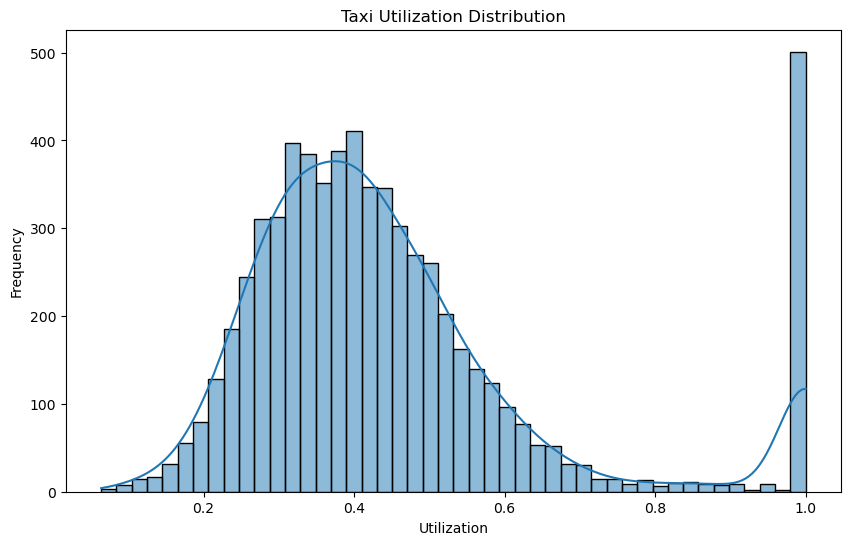

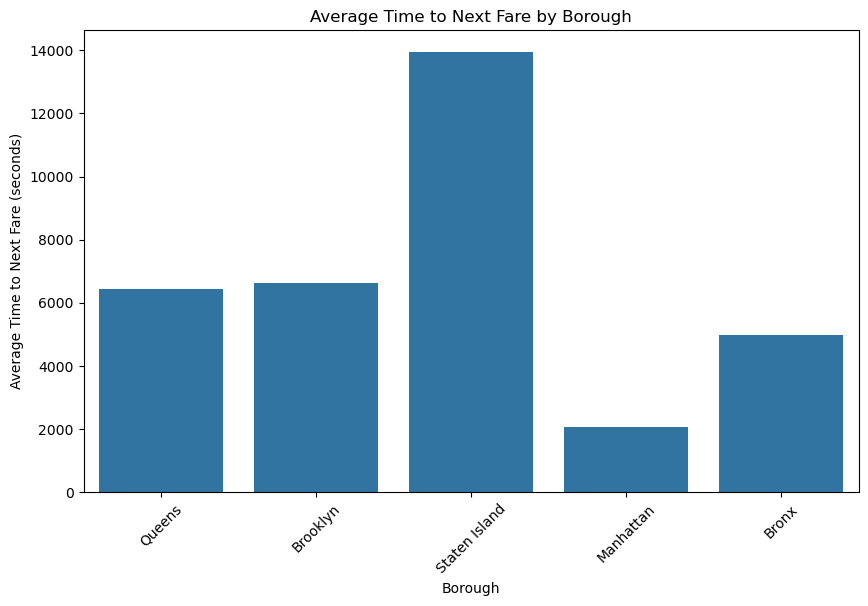

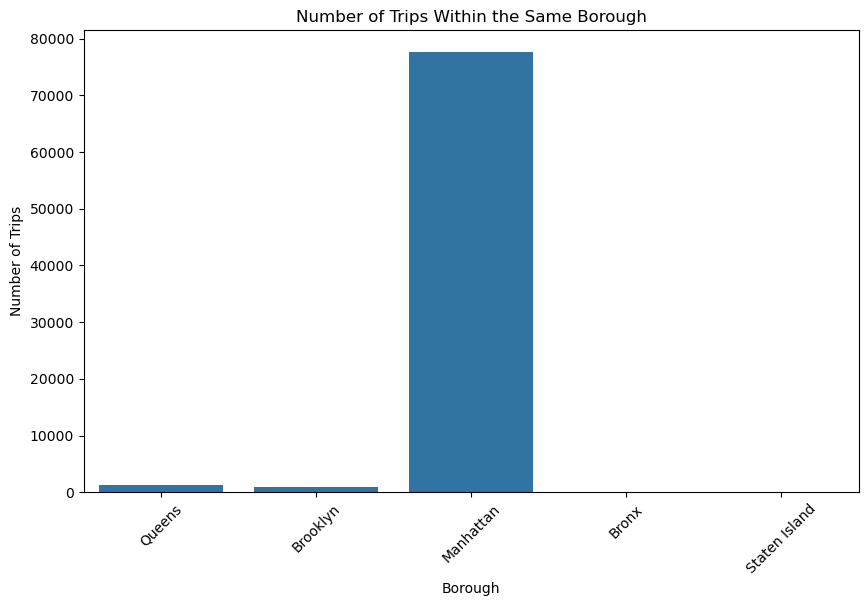

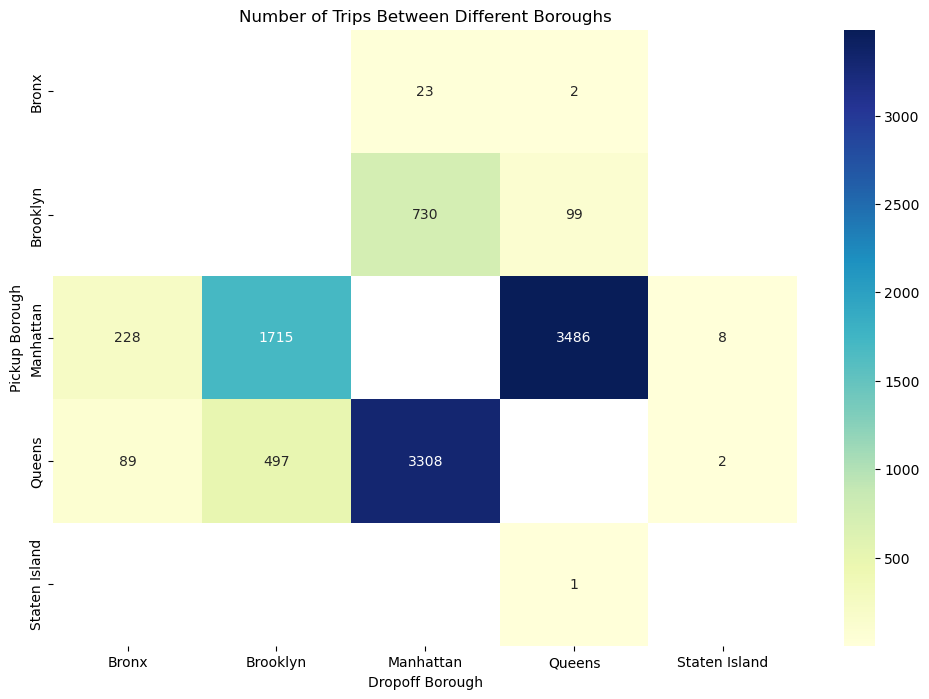

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Spark DataFrames to Pandas DataFrames for plotting
utilization_pd_df = utilization_df.toPandas()
next_fare_pd_df = next_fare_df.toPandas()
same_borough_pd_df = same_borough_df.toPandas()
diff_borough_pd_df = diff_borough_df.toPandas()

# Plot utilization
plt.figure(figsize=(10, 6))
sns.histplot(utilization_pd_df['utilization'], kde=True)
plt.title('Taxi Utilization Distribution')
plt.xlabel('Utilization')
plt.ylabel('Frequency')
plt.show()

# Plot average time to next fare by borough
plt.figure(figsize=(10, 6))
sns.barplot(x='dropoff_borough', y='avg_time_to_next_fare', data=next_fare_pd_df)
plt.title('Average Time to Next Fare by Borough')
plt.xlabel('Borough')
plt.ylabel('Average Time to Next Fare (seconds)')
plt.xticks(rotation=45)
plt.show()

# Plot trips within the same borough
plt.figure(figsize=(10, 6))
sns.barplot(x='pickup_borough', y='count', data=same_borough_pd_df)
plt.title('Number of Trips Within the Same Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.show()

# Plot trips between different boroughs
plt.figure(figsize=(12, 8))
pivot_df = diff_borough_pd_df.pivot_table(index='pickup_borough', columns='dropoff_borough', values='count', aggfunc='sum')
sns.heatmap(pivot_df, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Number of Trips Between Different Boroughs')
plt.xlabel('Dropoff Borough')
plt.ylabel('Pickup Borough')
plt.show()
